In [29]:
import os
import cv2
import glob
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce
from operator import concat
from sklearn.svm import SVC
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.combine import SMOTEENN 



# 1. Deal with initial Data and produce cutted data

In [30]:
"""Because we use different app, so we use different methods to deal with"""
def cutting_file(file_path, file, opath, wnum, cname):
    """Cutting sample into windows, no overlap"""
    if cname=="Walking": # for Walking 
        wsize = 36000
        pf_acc = pd.read_csv(file_path+"/"+file)
        pf_gyr = pd.read_csv(file_path+"/Gyroscope.csv")
        window_num = pf_acc.shape[0] // wsize # how many samples in this file
        file = file.replace(".csv", "")
        for i in range(window_num):
            wnum = wnum +1
            if wsize < pf_acc.shape[0]:
                st_data = pd.concat([pf_acc.iloc[i*wsize:(i+1)*wsize, 2:], pf_gyr.iloc[i*wsize:(i+1)*wsize, 2:]], axis=1)
                st_data.columns = ['Accelerometer_Z','Accelerometer_Y','Accelerometer_X','Gyroscope_Z','Gyroscope_Y',
                  'Gyroscope_X']
                st_data.to_csv(opath+"/"+cname.lower()+str(wnum)+".csv", index=None)
            else:
                st_data = pd.concat([pf_acc.iloc[:, 2:], pf_gyr.iloc[:, 2:]], axis=1)
                st_data.columns = ['Accelerometer_Z','Accelerometer_Y','Accelerometer_X','Gyroscope_Z','Gyroscope_Y',
                  'Gyroscope_X']
                st_data.to_csv(opath+"/"+cname.lower()+str(wnum)+".csv", index=None)
        return wnum
    elif cname=="Running": 
        wsize = 6000
        pf_acc = pd.read_csv(file_path+"/"+file)
        pf_gyr = pd.read_csv(file_path+"/Gyroscope.csv")
        window_num = pf_acc.shape[0] // wsize # how many samples in this file
        file = file.replace(".csv", "")
        for i in range(window_num):
            wnum = wnum +1
            if wsize < pf_acc.shape[0]:
                st_data = pd.concat([pf_acc.iloc[i*wsize:(i+1)*wsize, 2:], pf_gyr.iloc[i*wsize:(i+1)*wsize, 2:]], axis=1)
                st_data.columns = ['Accelerometer_Z','Accelerometer_Y','Accelerometer_X','Gyroscope_Z','Gyroscope_Y',
                  'Gyroscope_X']
                st_data.to_csv(opath+"/"+cname.lower()+str(wnum)+".csv", index=None)
            else:
                st_data = pd.concat([pf_acc.iloc[:, 2:], pf_gyr.iloc[:, 2:]], axis=1)
                st_data.columns = ['Accelerometer_Z','Accelerometer_Y','Accelerometer_X','Gyroscope_Z','Gyroscope_Y',
                  'Gyroscope_X']
                st_data.to_csv(opath+"/"+cname.lower()+str(wnum)+".csv", index=None)
        return wnum
    
    elif cname == "Standing":
        wnum = wnum + 1
        pf_acc = pd.read_csv(file_path+"/"+file)
        pf_gyr = pd.read_csv(file_path+"/Gyroscope.csv")
        st_data = pd.concat([pf_acc.iloc[:, 2:], pf_gyr.iloc[:, 2:]], axis=1)
        st_data.columns = ['Accelerometer_Z','Accelerometer_Y','Accelerometer_X',\
            'Gyroscope_Z','Gyroscope_Y', 'Gyroscope_X']
        st_data.to_csv(opath+"/"+cname.lower()+str(wnum)+".csv", index=None)
        return wnum
    elif (cname == "Upstairs") or (cname == "Downstairs"):
        wnum = wnum +1
        pf = pd.read_csv(file_path+file, header=1, sep=";")
        st_data = pf[["ACCELEROMETER Z (m/s²)", "ACCELEROMETER Y (m/s²)", "ACCELEROMETER X (m/s²)", \
            "GYROSCOPE Z (rad/s)","GYROSCOPE Y (rad/s)","GYROSCOPE X (rad/s)"]]
        st_data.columns = ['Accelerometer_Z','Accelerometer_Y','Accelerometer_X',\
            'Gyroscope_Z','Gyroscope_Y', 'Gyroscope_X']
        st_data.to_csv(opath+"/"+cname.lower()+str(wnum)+".csv", index=None)
        return wnum

    


In [31]:
def divide_long_data(wpath, opath, cname, name):
    wnum = 0
    for dirpath, dirnames, filenames in os.walk(wpath):
        for file in filenames:
            if file == name or file.startswith(cname) : # z, y, x
                wnum = cutting_file(dirpath, file, opath, wnum, cname)

In [32]:
"""1-1 Divide the csv data into different files"""
class_name = ["Downstairs", "Running", "Standing", "Upstairs",  "Walking"]
for cname in class_name:
    wpath = "Dataset/Initial_data/"+cname+"/"
    opath = "Dataset/Cutted_data/"+cname.lower()+"_whole"
    divide_long_data(wpath, opath, cname, name="Accelerometer.csv")
    print("Finished " + cname)


Finished Downstairs
Finished Running
Finished Standing
Finished Upstairs
Finished Walking


# 2 Read data and construct labels

For each class, we utilze ACCELEROMETER z, y, x, and GYROSCOPE z, y ,x information

In [33]:
# for sample in data, the colomn 0, 1, 2 is ACCELEROMETER z, y, x, colomn 3, 4, 5 is Gyroscope z, y, x
class_name = ["Downstairs", "Running", "Standing", "Upstairs",  "Walking"]
data = []
labels = []
for i_class in class_name:
    for each_file in glob.glob("Dataset/Cutted_data/"+i_class.lower()+"_whole/"+"/*.csv"):
        c_data = pd.read_csv(each_file)
        labels.append(i_class)
        data.append(c_data)

# 3 Select Features

In [34]:
data_feature = []
for j_sample in data:    
    sample_feature = []
    # # use feature mean for each column
    # j_mean = np.mean(j_sample, axis=0)
    # j_var = np.var(j_sample, axis=0)
    j_above_mean = j_sample.apply(lambda x: np.sum(x > x.mean()))
    # j_max = np.max(j_sample, axis=0)
    # j_min = np.min(j_sample, axis=0)
    # j_std = np.std(j_sample, axis=0)
    # j_negative_count = j_sample.apply(lambda x: np.sum(x < 0))
    # j_positive_count = j_sample.apply(lambda x: np.sum(x > 0))
    # j_energy = j_sample.apply(lambda x: np.sum(x**2)/100)
    # j_avg_abs_diff = j_sample.apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    
    for item_list in [j_above_mean]:#j_mean, j_var, , j_above_mean]:#[j_mean, j_max, j_min, j_std,j_var, j_negative_count, j_positive_count,\
        #  j_energy, j_avg_abs_diff, j_above_mean]:
        sample_feature.extend(item_list)
    data_feature.append(sample_feature) #np.array(class_feature)
data_feature = np.array(data_feature)

# 4. Rebalence the data (for training dataset)

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(data_feature, labels, test_size=0.2,random_state=10, shuffle=True)

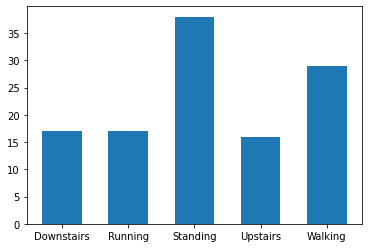

In [36]:
"""Initial Training Data"""
label_count = Counter(ytrain)
label_count = sorted(label_count.items())
l_keys= [item[0] for item in label_count]
l_values = [item[1] for item in label_count]
plt.bar(l_keys, l_values, width=0.6)
plt.show()

In [37]:
label_count

[('Downstairs', 17),
 ('Running', 17),
 ('Standing', 38),
 ('Upstairs', 16),
 ('Walking', 29)]

Resampled dataset shape Counter({'Downstairs': 16, 'Running': 16, 'Standing': 16, 'Upstairs': 16, 'Walking': 16})


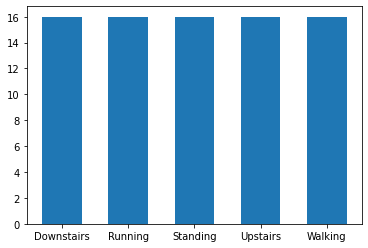

In [38]:
"""After sampling"""
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
xtrain, ytrain = cc.fit_resample(xtrain, ytrain)
print('Resampled dataset shape %s' % Counter(ytrain))

#plot after balacing
label_count2 = Counter(ytrain)
label_count2 = sorted(label_count2.items())
l_keys2= [item[0] for item in label_count2]
l_values2 = [item[1] for item in label_count2]
plt.bar(l_keys2, l_values2, width=0.6)
plt.show()

# 5. Spread of feature

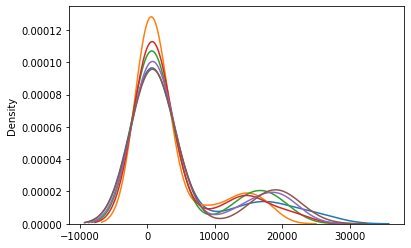

In [39]:
"""Initial spread of feature, Just show it, because Random forest no need scalar"""
for i in range(xtrain.shape[1]):
    sns.kdeplot(xtrain[:,i])

['Model/scaler.joblib']

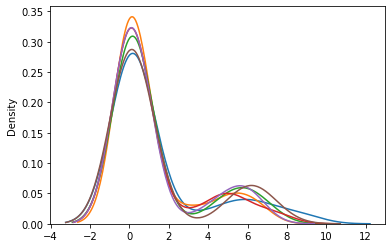

In [40]:
"""After scaler: because random forest, so we do not use it"""
scaler = RobustScaler()
xtrain = scaler.fit_transform(xtrain)
for i in range(xtrain.shape[1]):
    sns.kdeplot(xtrain[:,i])
joblib.dump(scaler, "Model/scaler.joblib")

# 6. Model

Average Cross Validation Score from Training:
0.8125


Confusion Matrix:
[[ 4  0  0  0  0]
 [ 0  3  0  0  0]
 [ 1  0 11  0  0]
 [ 2  0  0  2  0]
 [ 0  0  0  0  7]]


Test Statistics:
              precision    recall  f1-score   support

  Downstairs       0.57      1.00      0.73         4
     Running       1.00      1.00      1.00         3
    Standing       1.00      0.92      0.96        12
    Upstairs       1.00      0.50      0.67         4
     Walking       1.00      1.00      1.00         7

    accuracy                           0.90        30
   macro avg       0.91      0.88      0.87        30
weighted avg       0.94      0.90      0.90        30



Testing Accuracy: 0.9


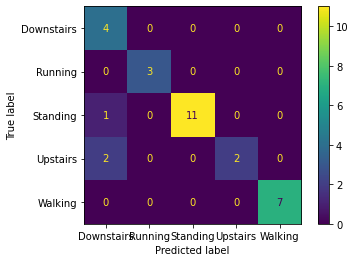

['Model/model.joblib']

In [41]:
# xtrain, xtest, ytrain, ytest = train_test_split(data_feature, labels, test_size=0.30,random_state=42)
# clf = SVC()
# clf = SVC(kernel="linear", degree=2)
clf = RandomForestClassifier(random_state=600)
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
xtest = scaler.transform(xtest)
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))


cm_display = ConfusionMatrixDisplay(cm, display_labels=class_name)
cm_display.plot()
# plt.savefig("Pictures/activity_rec.png")
plt.show()

joblib.dump(clf, "Model/model.joblib")



# 7. Real-Time Predictions

In [42]:
# read pred data
true_label = ["Standing", "Running", "Walking"]
pred_data = []
for item in true_label:
    pred_acc = pd.read_csv("Dataset/Pred/"+item+"/Accelerometer.csv")
    pred_gry = pd.read_csv("Dataset/Pred/"+item+"/Gyroscope.csv")
    pred_data.append(pd.concat([pred_acc.iloc[:, 2:], pred_gry.iloc[:, 2:]], axis=1))

# feature
pred_feature = []
for c_item in pred_data:
    pred_mean = np.mean(c_item, axis=0)
    pred_var = np.var(c_item, axis=0)
    pred_above_mean = c_item.apply(lambda x: np.sum(x > x.mean()))
    c_feature = []
    for item_list in [pred_mean, pred_var, pred_above_mean]:
        c_feature.extend(item_list)
    pred_feature.append(c_feature)

pred_feature = np.array(pred_feature)

# Pred
pred_scaler = joblib.load("Model/scaler.joblib")
pred_model = joblib.load("Model/model.joblib")
pred_feature = pred_scaler.transform(pred_feature)
pred_ = pred_model.predict(pred_feature)

print("True label is: ", true_label)
print("Pred label is: ", pred_)


ValueError: X has 18 features, but RobustScaler is expecting 6 features as input.